In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder

In [61]:
train_df = pd.read_csv('./archive/cbb.csv')
train_df = train_df[train_df['SEED'] < 17]
test_df = pd.read_csv('./archive/cbb21.csv')
test_df = test_df[test_df['SEED'] < 17]


train_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


# To reduce the # of conferences, i select conferences with at least 19 entires in the data set.

## this choice is to select big conferences to see if they conferences have any statistics trends or similarities

### would have done 20, but Amer is lower due to the splitting of Amer and BE

In [62]:
conf_train = train_df.groupby('CONF')
conf_test = test_df.groupby('CONF')
#conf_train.size()

In [63]:
#boxplot = conf_train.boxplot(column=['ADJOE'])
conferences = list(['A10', 'ACC','Amer', 'B10', 'B12', 'BE', 'SEC', 'P12'])
big_conf = []
for index, row in train_df.iterrows():
    #print(index)
    c = row["CONF"]
    if c in conferences:
        big_conf.append(c) 
    else:
        big_conf.append('OTH')
        
train_df['CLUS'] = big_conf

In [64]:
train_df['CLUS']

0       ACC
1       B10
2       B10
3       B12
4       OTH
       ... 
2450    B10
2451    P12
2452    P12
2453    A10
2454    OTH
Name: CLUS, Length: 476, dtype: object

Now we have groups by big conferences, now to see counts, boxplots, and stats

<Figure size 1080x720 with 0 Axes>

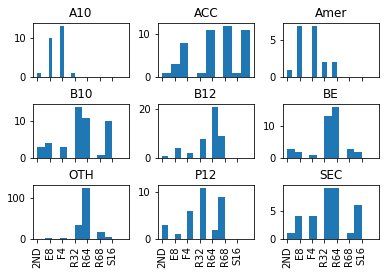

In [65]:
clustering = train_df.groupby('CLUS')
plt.figure(figsize=(15,10))

train_df['POSTSEASON'].hist(by=train_df['CLUS'],sharex=True)
plt.show()

# These histograms show a little, but can't really read it since the axes are whack

## first, im going to see the separations S16/R32 cutoff

In [89]:
y_post = np.array(train_df['POSTSEASON'])
y_post = y_post.reshape(len(y_post),1)
cats = np.array(['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68'][::-1])
cats = list(cats.reshape(1,-1))

# turn categorical y to one-hot vector, then group
onehot = OneHotEncoder(categories=cats, sparse=False)
onehot_encode = onehot.fit_transform(y_post)
# creating true classes, 0 - Rd64/32 and 1 - Rd16/8/4
y_group=np.array([None]*onehot_encode.shape[0])
for i,row in enumerate(onehot_encode):
## for grouping, 1 if sweet 16 or further 0 for 32 or worse #:1 classi mbalance
    idx = list(np.where(row == 1)[0])
   
    if idx[0] < 2.5:
        y_group[i] = 0
    elif idx[0] > 2.5:
        y_group[i] = 1
        
y_class = y_group.astype(int)

In [90]:
train_df['CUTOFF'] = y_class

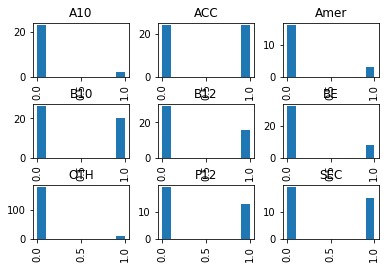

In [91]:
train_df['CUTOFF'].hist(by=train_df['CLUS'])
plt.show()

{'R68': 0, 'R64': 1, 'R32': 2, 'S16': 3, 'E8': 4, 'F4': 5, '2ND': 6, 'Champions': 7}


Text(0.5, 1.0, "['By-Round Probability of a random team selected from a given conf will make the given round.']")

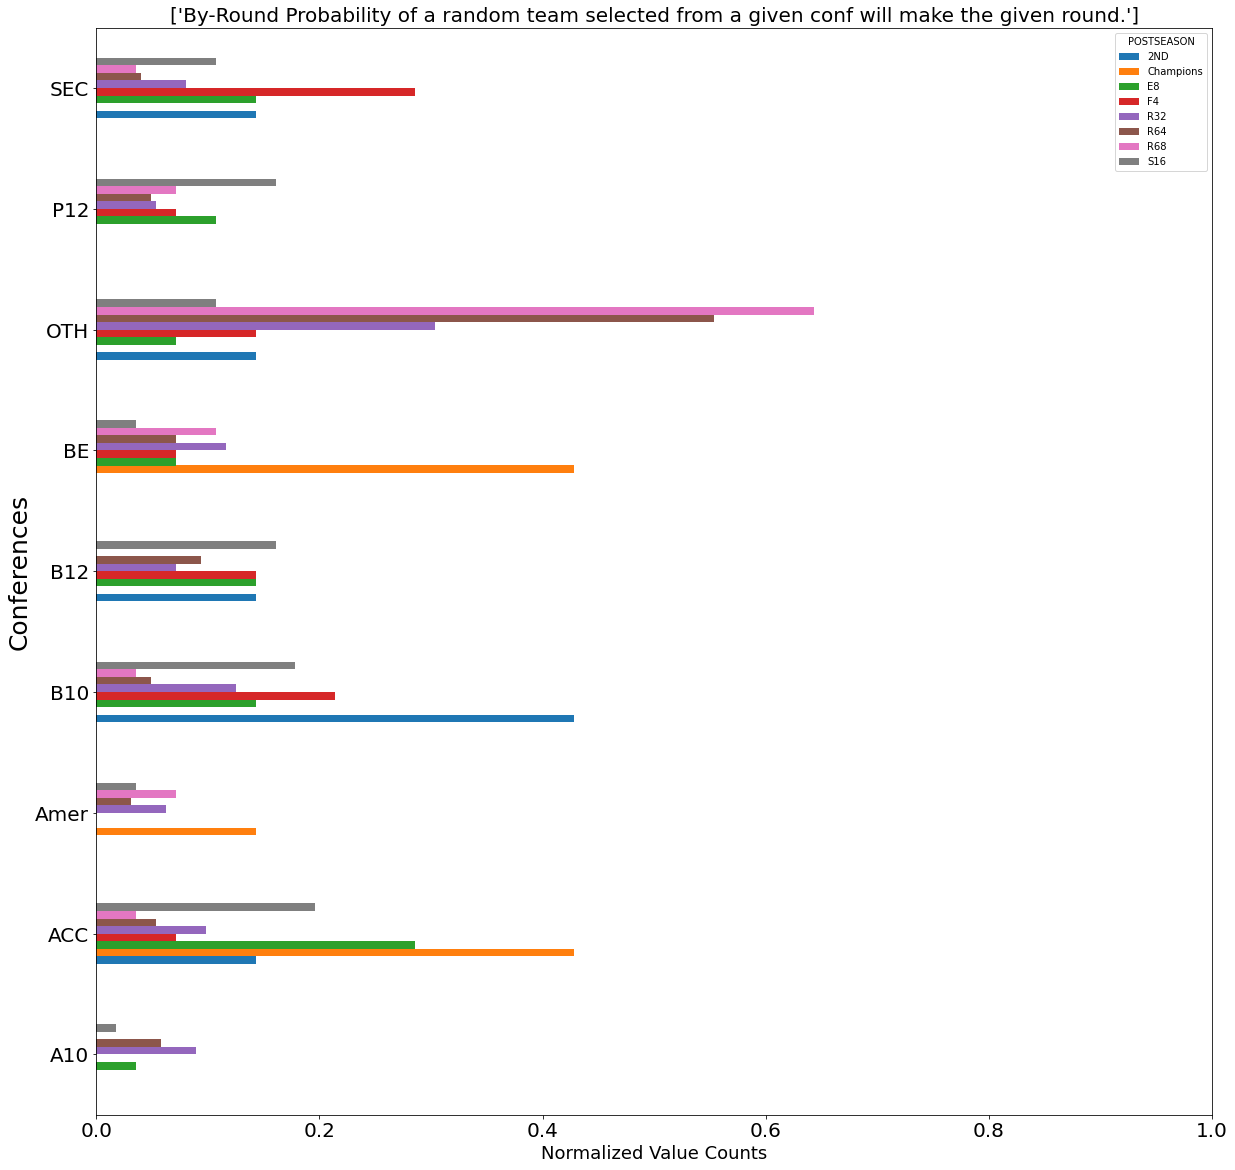

In [115]:
mapping = {cat: i for i, cat in enumerate(cats[0])}
print(mapping)
key = train_df['POSTSEASON'].map(mapping)
train_df = train_df.iloc[key.argsort()]
ax = train_df.groupby('POSTSEASON').CLUS.value_counts(normalize=True).unstack(0).plot.barh(figsize=(20,20),fontsize=20)
ax.set_xlim([0,1])
ax.set_ylabel('Conferences',fontsize=25)
ax.set_xlabel('Normalized Value Counts', fontsize=18)
ax.set_title(['By-Round Probability of a random team selected from a given conf will make the given round.'],fontsize=20)


# AT THIS POINT, i realize it is far too granular to do by-round. Also, i fail to see any relevant info from this plot

## I go back to see sweet 16 and above versus early round losers


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,CLUS,CUTOFF
10,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016,BE,1
11,Villanova,BE,40,36,128.4,94.1,0.9725,59.5,48.5,15.0,...,49.0,40.1,31.7,69.6,10.6,Champions,1.0,2018,BE,1
13,Louisville,BE,40,35,115.9,84.5,0.9743,50.6,44.8,18.3,...,43.4,33.3,31.8,67.1,9.0,Champions,1.0,2013,BE,1
7,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015,ACC,1
8,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,...,45.7,39.5,28.9,60.7,11.1,Champions,1.0,2019,ACC,1
9,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,...,46.3,35.5,33.9,72.8,8.4,Champions,1.0,2017,ACC,1
12,Connecticut,Amer,40,32,112.5,91.3,0.9171,51.5,44.6,17.3,...,42.2,38.7,33.0,64.8,4.7,Champions,7.0,2014,Amer,1


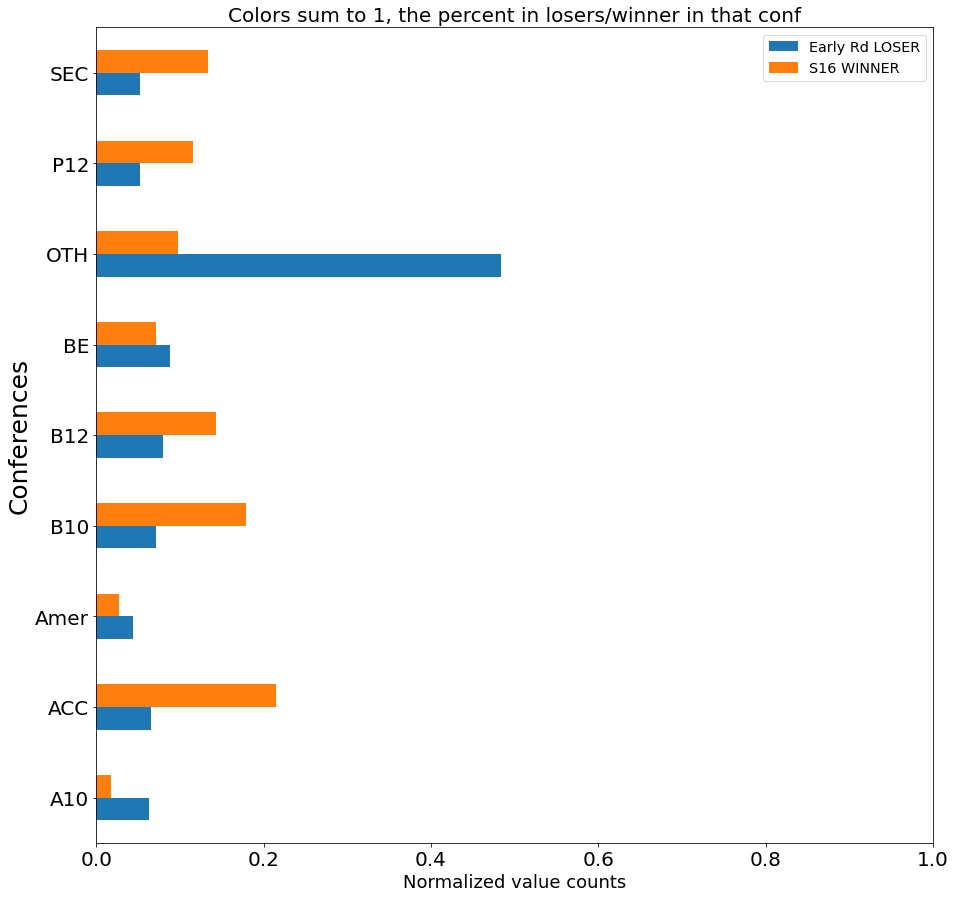

In [114]:
ax = train_df.groupby('CUTOFF').CLUS.value_counts(normalize=True).unstack(0).plot.barh(figsize=(15,15),fontsize=20)
ax.set_xlim([0,1])
ax.set_ylabel('Conferences',fontsize=25)
ax.set_xlabel('Normalized value counts', fontsize=18)
ax.set_title('Colors sum to 1, the percent in losers/winner in that conf', fontsize=20)
ax.legend(['Early Rd LOSER','S16 WINNER'],fontsize='x-large')

# Here, we see a general uniform trend. That is, on average, conference counts in the S16 are somewhat uniform, with ACC Amer BE exceptions

# the issue is, this does not give any info on why, and in particular, i want to explore the likelihood of being a WINNER based on conference

## end goal is to find if a particular conference has a higher likelihood of having a given team from their conference advance far in the tournament

### my criteria being S16